In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
import seaborn as sns
sns.set_style("whitegrid")

sys.path.append("../../pyelftools")             # relative location of pyelftools repo cloned from github
from elftools.elf.elffile import ELFFile
from tqdm import tqdm
from scipy import stats
from collections import Counter

In [2]:
path = "sh4/"
files = os.listdir(path)
len(files)

11861

In [3]:
np.random.seed(1)
sample_files = np.random.choice(files, size=1000, replace=False)

In [4]:
def extract_code(path, file_list, min_file_size=10000, n_files=100):
    
    code_dict = {}
    counter = 0
    
    for file in file_list:
        with open(path + file, "rb") as f:
            try:
                elffile = ELFFile(f)
            except:
                continue
        
            try:
                text_section_header = elffile.get_section_by_name(".text").header
            except:
                continue
            offset = text_section_header.sh_offset
            size = text_section_header.sh_size
        
            if size >= min_file_size: # minimum size cutoff: 10kb of machine code
                counter += 1
                f.seek(offset)
                code_dict[file] = list(f.read(size))
                if counter == n_files: # number of files to select samples from
                    break
            else:
                continue
                
    return code_dict

In [6]:
sample_code_dict = extract_code(path, sample_files)
len(sample_code_dict.keys())

100

In [7]:
for file, code in sample_code_dict.items():
    print("%s\t%s\t%s" %(file, str(len(code)), code[:10]))

923321df25a548e2545cc8308f4a4e47	285400	[198, 47, 6, 199, 5, 220, 70, 230, 5, 209]
6866b4300c887b50138e7baea671202d	21808	[134, 47, 1, 225, 150, 47, 173, 199, 166, 47]
0f8eabef111032550066ad41c719decc	14652	[0, 238, 246, 101, 243, 102, 70, 47, 6, 208]
8b1f5dfe15a04bf0ba16faf67b6a94ff	44324	[134, 47, 150, 47, 166, 47, 182, 47, 198, 47]
f44987a195d637b5eb62df82c0b7b228	111092	[134, 47, 86, 199, 150, 47, 64, 226, 166, 47]
1fcc52d24c52eb63bf6ff925ffb4a2bb	55540	[134, 47, 118, 199, 150, 47, 83, 104, 166, 47]
efcabfdf1789a9827dfd9ad98f2b900d	88052	[134, 47, 93, 199, 150, 47, 166, 47, 182, 47]
a9915c14ea362cfc7527a316e1188191	1259196	[134, 47, 255, 229, 150, 47, 166, 47, 182, 47]
67bf16d3261b7da6ff50d07045c8fcb2	247896	[5, 209, 34, 79, 11, 65, 9, 0, 4, 209]
cb01086bd058ae01b9363bf5882f500b	85620	[134, 47, 86, 199, 150, 47, 64, 226, 166, 47]
4acb641a51884c22d910d8d34d322a87	12356	[134, 47, 141, 199, 150, 47, 0, 228, 166, 47]
4309bd91926f26a8949265d76754e5a4	43492	[134, 47, 34, 79, 72, 36, 9, 1

In [8]:
def plot_dists(dictionary):
    for file, code in dictionary.items():
        sns.distplot(code, 
                     bins = 256,
                     kde=False,
                     hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':0.1}, 
                     kde_kws={'cumulative': True},
                     norm_hist=True,
                     color="blue")
    plt.show()

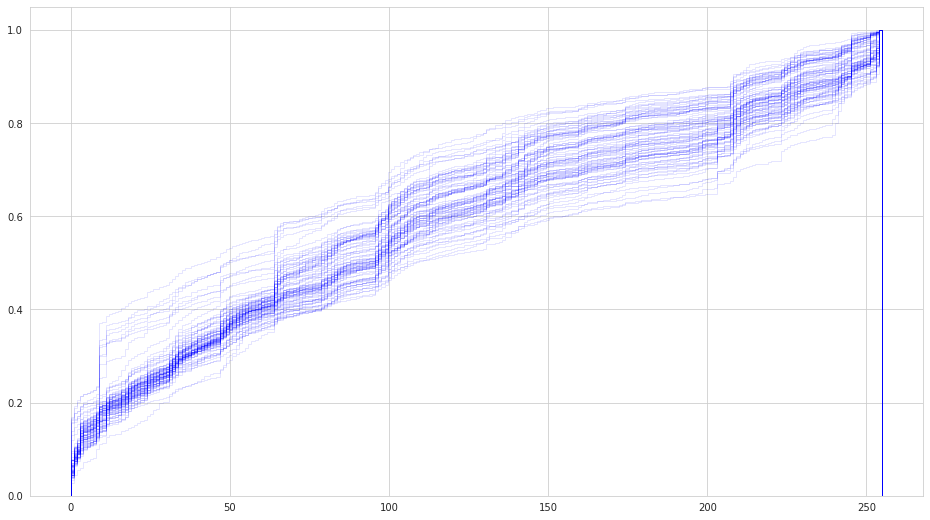

In [9]:
plot_dists(sample_code_dict)

In [10]:
def plot_sample(sample):
    sns.distplot(sample,
                 norm_hist=True,     
                 kde=False,
                 hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':0.1, 'alpha':0.1},
                 kde_kws={'cumulative': True},  # want CDF
                 bins=256,                      
                 color="blue")

def create_code_samples(sample_size, n_rows, sample_source, plot=False):
    
    samples_df = pd.DataFrame(index=np.arange(0, n_rows), columns=[i for i in range(sample_size)])
    
    for i in tqdm(np.arange(0, n_rows)):
        sample = np.random.choice(sample_source, size=sample_size, replace=True)
        samples_df.loc[i] = sorted(sample)
        
    samples_mean = samples_df.mean(axis = 0)
    
    if plot is True:
        sns.distplot(samples_mean, norm_hist=True, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},kde_kws={'cumulative': True},bins=256,color="red")
        plt.show()    
    
    return samples_mean

In [11]:
def create_reference_distribution(code_dictionary, sample_size, n_samples):
    # create data frame to hold mean sample of each file's code
    means_df = pd.DataFrame(index=list(code_dictionary.keys()),
                            columns=[i for i in range(sample_size)])
    
    # for each file's code, store mean of the samples in data frame
    for file, code in code_dictionary.items():
        means_df.loc[file] = create_code_samples(sample_size,
                                                 n_samples,
                                                 code)
    # average all samples means together
    mean = means_df.mean(axis = 0)
    median = means_df.median(axis = 0)
    return mean, median

In [12]:
mean, median = create_reference_distribution(sample_code_dict, 1000, 1000)

100%|██████████| 1000/1000 [00:58<00:00, 17.07it/s]


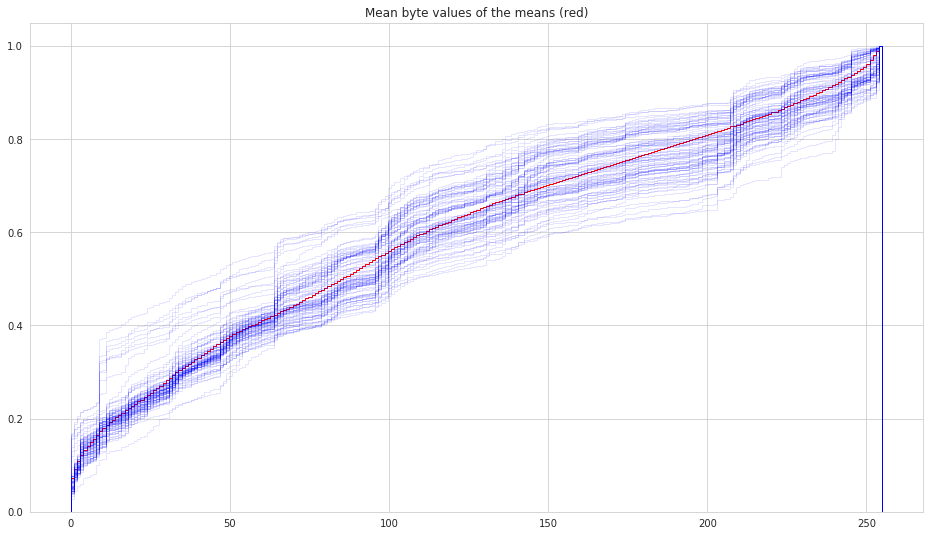

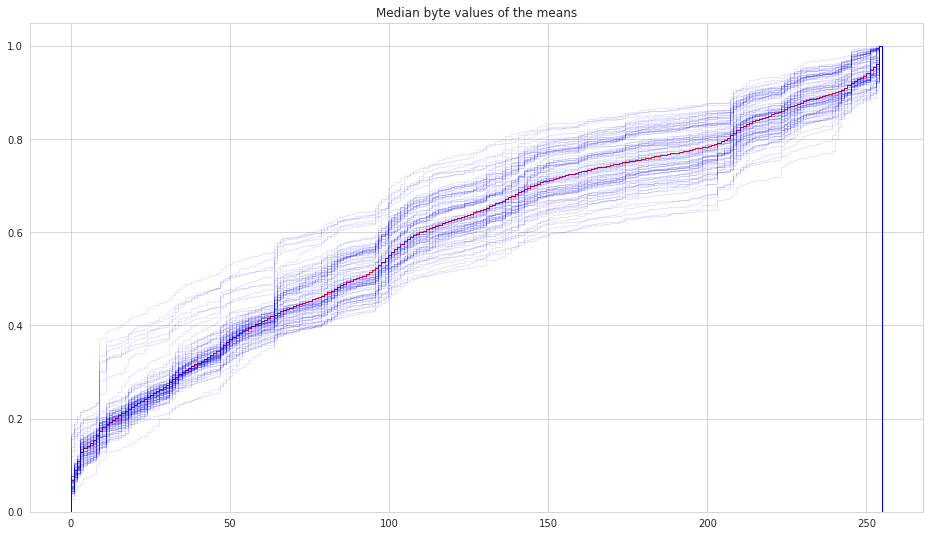

In [13]:
sns.distplot(mean, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Mean byte values of the means (red)")
plot_dists(sample_code_dict)


sns.distplot(median, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Median byte values of the means")
plot_dists(sample_code_dict)

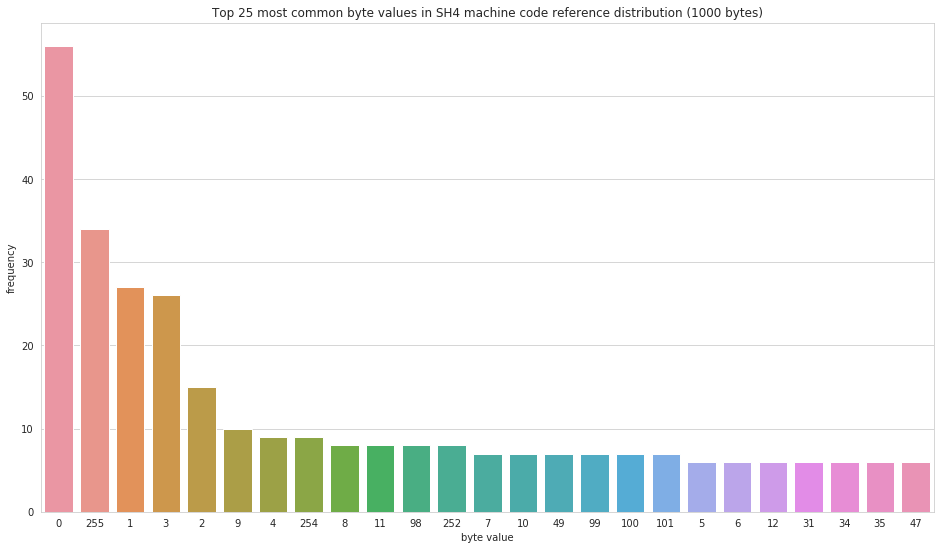

In [14]:
rounded_medians = [round(i) for i in median]
sorted_counts = sorted(Counter(rounded_medians).items(), key = lambda x: x[1], reverse=True)

counts_df = pd.DataFrame(sorted_counts[:25])
counts_df = counts_df.rename(columns={0:"byte value", 1:"frequency"})

sns.barplot(x="byte value", y="frequency", data=counts_df, order=counts_df["byte value"])
plt.title("Top 25 most common byte values in SH4 machine code reference distribution (1000 bytes)")
plt.show()

In [15]:
[hex(i) for i in list(dict(sorted_counts).keys())[:25]]

['0x0',
 '0xff',
 '0x1',
 '0x3',
 '0x2',
 '0x9',
 '0x4',
 '0xfe',
 '0x8',
 '0xb',
 '0x62',
 '0xfc',
 '0x7',
 '0xa',
 '0x31',
 '0x63',
 '0x64',
 '0x65',
 '0x5',
 '0x6',
 '0xc',
 '0x1f',
 '0x22',
 '0x23',
 '0x2f']

In [16]:
# get pool of test files
test_pool = [file for file in files if file not in sample_files]

# select test files
np.random.seed(1)
test_files = np.random.choice(test_pool, size=3000, replace=False)

In [17]:
len(test_files)

3000

In [18]:
# check for overlap between files that the reference distribution was built from and the files used for testing
list(set(sample_code_dict.keys()) & set(test_files))

[]

In [19]:
test_code_dict = extract_code(path, test_files, n_files=3000)

In [20]:
for file, code in test_code_dict.items():
    print("%s\t%s\t%s" % (file, str(len(code)), code[:10]))

0f3deb0b24afa09c7fcd532ae8511d11	60244	[134, 47, 61, 199, 150, 47, 166, 47, 182, 47]
72462906668d47dbf87af14767d4c739	81356	[134, 47, 67, 104, 150, 47, 166, 47, 182, 47]
5021eb87bb946134348d3e68bd1f24df	69196	[134, 47, 34, 79, 252, 127, 67, 97, 8, 113]
4bd55d9b1a5ccbde435865e1fdf4b231	48640	[134, 47, 150, 47, 166, 47, 182, 47, 198, 47]
f0995d991f0a7e6fe6cb4e9fe7df37a4	85960	[0, 238, 246, 101, 243, 102, 70, 47, 6, 208]
a1142eff805717d5e38c1a1a8729484c	1291536	[134, 47, 71, 199, 150, 47, 166, 47, 198, 47]
6fddc165973250960f96e116098105bc	3866556	[0, 238, 246, 101, 243, 102, 70, 47, 6, 208]
d9f0b71741fcd1bb888a47b683a2fc97	44640	[134, 47, 161, 199, 150, 47, 24, 230, 166, 47]
013dbe033f01ffb01e416e959d675f7f	225540	[134, 47, 45, 199, 150, 47, 166, 47, 182, 47]
671fa5875e9e4d9ccf9b1ca07b00811a	212208	[134, 47, 120, 199, 150, 47, 166, 47, 182, 47]
870d053255f1cc4dd33d6d342ba4c28a	21116	[134, 47, 186, 199, 150, 47, 166, 47, 182, 47]
0dc97bd91c8c0347f39f1bc5d21aed65	303536	[134, 47, 150, 47, 1

In [21]:
len(test_code_dict.keys())

920

In [22]:
test_results_df = pd.DataFrame(index=test_code_dict.keys(),
                               columns=["size", "wasserstein distance","energy distance", "mean", "median", "standard deviation"])

for file, code in test_code_dict.items():
    test_results_df.loc[file]["size"] = len(code)
    test_results_df.loc[file]["wasserstein distance"] = stats.wasserstein_distance(median, code)
    test_results_df.loc[file]["energy distance"] = stats.energy_distance(median, code)
    test_results_df.loc[file]["mean"] = np.mean(code)
    test_results_df.loc[file]["median"] = np.median(code)
    test_results_df.loc[file]["standard deviation"] = np.std(code)
    
print(test_results_df.shape)
test_results_df

(920, 6)


,size,wasserstein distance,energy distance,mean,median,standard deviation
0f3deb0b24afa09c7fcd532ae8511d11,60244,3.58042,0.349283,101.529,87,82.1765
72462906668d47dbf87af14767d4c739,81356,11.4801,1.08961,91.9592,72,78.2635
5021eb87bb946134348d3e68bd1f24df,69196,12.1268,1.15243,91.1851,69,77.4815
4bd55d9b1a5ccbde435865e1fdf4b231,48640,10.9842,1.09088,92.7447,79,76.8539
f0995d991f0a7e6fe6cb4e9fe7df37a4,85960,10.5368,1.12696,93.2122,81,79.7396
...,...,...,...,...,...,...
a47202ed38a7b9e892995092f08d62e6,261408,4.90747,0.546198,101.363,90,87.0948
f2435e9fc87dcea19997e616441df54c,16464,5.82733,0.598778,104.611,96,89.4937
c031aaa849e486f51116688b3c18b493,145124,2.0627,0.208169,102.215,85,83.8389
8c6e4422eb82bd66671728543bbeb473,42140,5.29716,0.506481,108.449,97,87.5199


In [23]:
test_results_df.mean()

size                    225137.578261
wasserstein distance         9.031299
energy distance              0.897316
mean                       100.034130
median                      84.972283
standard deviation          83.366000
dtype: float64

In [24]:
test_results_df.median()

size                    55064.000000
wasserstein distance        8.496425
energy distance             0.828074
mean                      100.710301
median                     85.000000
standard deviation         84.324608
dtype: float64

In [25]:
test_results_df["size"].sum()

207126572

In [26]:
test_results_df["size"].sum() / 1000000

207.126572

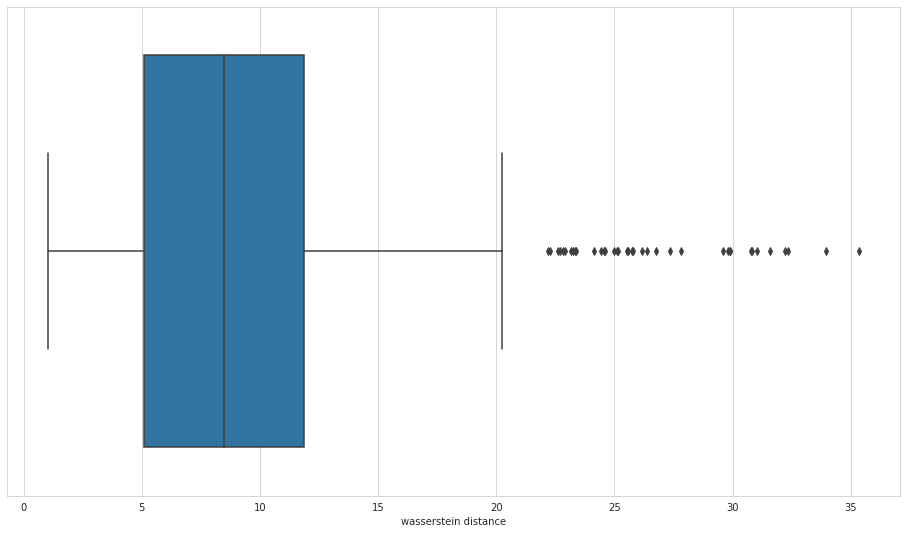

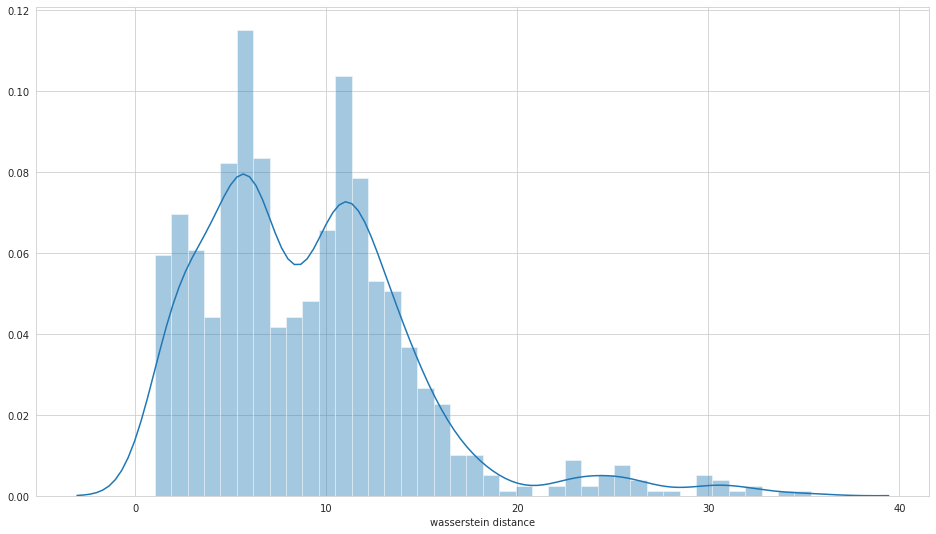

In [27]:
sns.boxplot(x="wasserstein distance", data=test_results_df)
plt.show()
sns.distplot(test_results_df["wasserstein distance"], bins=40)
plt.show()

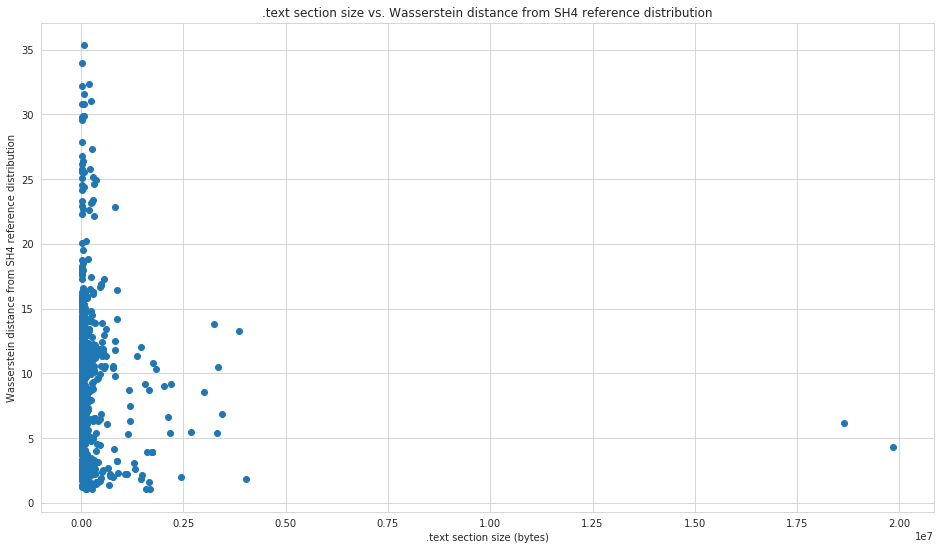

In [28]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from SH4 reference distribution")
plt.title(".text section size vs. Wasserstein distance from SH4 reference distribution")
plt.show()

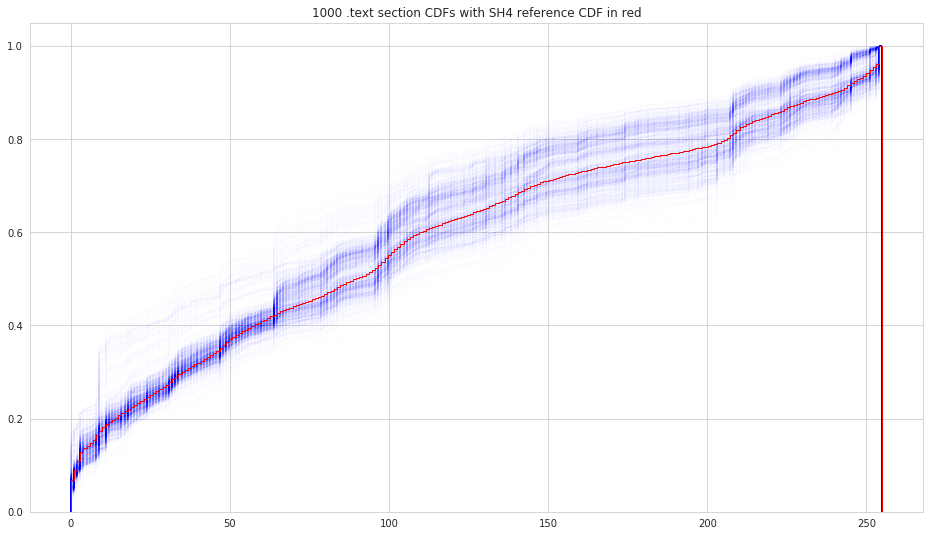

In [29]:
for code in test_code_dict.values():
    plot_sample(code)
    
sns.distplot(median, # reference distribution
             norm_hist=True,     
             kde=False,
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},
             kde_kws={'cumulative': True},
             bins=256,                      
             color="red")

plt.title("1000 .text section CDFs with SH4 reference CDF in red")
plt.show()

In [30]:
# export reference distribution
with open("SH4_reference", "wb") as f:
    pickle.dump(median, f)